In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='988b28be-4f20-4201-ba98-6556e720b247', project_access_token='p-31d075627f42281fa368bcdcef32f0e806d4e2ab')
pc = project.project_context


# MARATÓN BEHIND THE CODE 2020

## DESAFÍO 2: TORTUGA CODE

### Introducción

En proyectos de ciencia de datos destinados a construir modelos de *aprendizaje automático*, o aprendizaje estadístico, es muy inusual que los datos iniciales ya estén en el formato ideal para la construcción de modelos. Se requieren varios pasos intermedios de preprocesamiento de datos, como la codificación de variables categóricas, normalización de variables numéricas, tratamiento de datos faltantes, etc. La biblioteca **scikit-learn**, una de las bibliotecas de código abierto más populares para *aprendizaje automático* en el mundo, ya tiene varias funciones integradas para realizar las transformaciones de datos más utilizadas. Sin embargo, en un flujo común de un modelo de aprendizaje automático, es necesario aplicar estas transformaciones al menos dos veces: la primera vez para "entrenar" el modelo, y luego nuevamente cuando se envían nuevos datos como entrada para ser clasificados por este modelo.


### Trabajando scikit-learn

In [2]:
# Primero, realizamos la instalación de scikit-learn versión 0.20.0 en el Kernel de este notebook:
!pip install scikit-learn==0.23.2 --upgrade

Requirement already up-to-date: scikit-learn==0.23.2 in /opt/conda/envs/Python36/lib/python3.6/site-packages (0.23.2)


In [3]:
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /opt/conda/envs/Python36/lib/python3.6/site-packages (0.7.0)


In [4]:
import json
import requests
import itertools

import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import ExtraTreesClassifier

from matplotlib import pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

### Importar  un .csv a tu proyecto en IBM Cloud Pak for Data al Kernel de este notebook

In [5]:
# Primero, importaremos el conjunto de datos proporcionado para el desafío, que ya está incluido en este proyecto.

!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/maratonadev-la/desafio-2-2020/master/Assets/Data/dataset-tortuga-desafio-2.csv
df_training = pd.read_csv(r'dataset-tortuga-desafio-2.csv')
df_training.head()

--2020-09-07 06:44:27--  https://raw.githubusercontent.com/maratonadev-la/desafio-2-2020/master/Assets/Data/dataset-tortuga-desafio-2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2031803 (1.9M) [text/plain]
Saving to: ‘dataset-tortuga-desafio-2.csv.12’

100%[======================================>] 2,031,803   --.-K/s   in 0.06s   

2020-09-07 06:44:27 (34.6 MB/s) - ‘dataset-tortuga-desafio-2.csv.12’ saved [2031803/2031803]



Unnamed: 0               NAME   USER_ID  HOURS_DATASCIENCE  HOURS_BACKEND  \
0          28        Stormy Muto  58283940                7.0           39.0   
1          81       Carlos Ferro   1357218               32.0            0.0   
2          89  Robby Constantini  63212105               45.0            0.0   
3         138       Paul Mckenny  23239851               36.0           19.0   
4         143          Jean Webb  72234478               61.0           78.0   

   HOURS_FRONTEND  NUM_COURSES_BEGINNER_DATASCIENCE  \
0            29.0                               2.0   
1            44.0                               2.0   
2            59.0                               0.0   
3            28.0                               0.0   
4            38.0                               6.0   

   NUM_COURSES_BEGINNER_BACKEND  NUM_COURSES_BEGINNER_FRONTEND  \
0                           4.0                            0.0   
1                           0.0                            0.0   
2                           5.0                            4.0   
3                           5.0                            7.0   
4                          11.0                            0.0   

   NUM_COURSES_ADVANCED_DATASCIENCE  NUM_COURSES_ADVANCED_BACKEND  \
0                               2.0                           5.0   
1                               0.0                           5.0   
2                               0.0                           4.0   
3                               0.0                           5.0   
4                               4.0                           3.0   

   NUM_COURSES_ADVANCED_FRONTEND  AVG_SCORE_DATASCIENCE  AVG_SCORE_BACKEND  \
0                            0.0                   84.0               74.0   
1                            0.0                   67.0               45.0   
2                            1.0                    NaN               54.0   
3                            3.0                    NaN               71.0   
4                            0.0                   66.0               85.0   

   AVG_SCORE_FRONTEND                PROFILE  
0                 NaN     beginner_front_end  
1                 NaN     beginner_front_end  
2                47.0     advanced_front_end  
3                89.0  beginner_data_science  
4                 NaN     advanced_front_end

Tenemos 16 columnas presentes en el set de datos proporcionado, 15 de las cuales son variables features (datos de entrada) y una de ellas es una variable target (que queremos que nuestro modelo va a predecir).

Las variables features son:

    Unnamed: 0                          - Esta columna no tiene nombre y debe ser eliminada del dataset
    NAME                                - Nombre del estudiante
    USER_ID                             - Número de identificación del estudiante
    HOURS_DATASCIENCE                   - Número de horas de estudio en Data Science
    HOURS_BACKEND                       - Número de horas de estudio en Web (Back-End)
    HOURS_FRONTEND                      - Número de horas de estudio en Web (Front-End)
    NUM_COURSES_BEGINNER_DATASCIENCE    - Número de cursos de nivel principiante en Data Science completados por el estudiante
    NUM_COURSES_BEGINNER_BACKEND        - Número de cursos de nivel principiante en Web (Back-End) completados por el estudiante
    NUM_COURSES_BEGINNER_FRONTEND       - Número de cursos de nivel principiante en Web (Front-End) completados por el estudiante
    NUM_COURSES_ADVANCED_DATASCIENCE    - Número de cursos de nivel avanzado en Data Science completados por el estudiante
    NUM_COURSES_ADVANCED_BACKEND        - Número de cursos de nivel avanzado en Web (Back-End) completados por el estudiante
    NUM_COURSES_ADVANCED_FRONTEND       - Número de cursos de nivel avanzado en Web (Front-End) completados por el estudiante
    AVG_SCORE_DATASCIENCE               - Promedio acumulado en cursos de Data Science completados por el estudiante
    AVG_SCORE_BACKEND                   - Promedio acumulado en cursos de Web (Back-End) completados por el estudiante
    AVG_SCORE_FRONTEND                  - Promedio acumulado en cursos de Web (Front-End) completados por el estudiante
    
La variable target es:

    PROFILE                             - Perfil de carrera del estudiante (puede ser uno de 6)
    
        - beginner_front_end
        - advanced_front_end
        - beginner_back_end
        - advanced_back_end
        - beginner_data_science
        - advanced_data_science
        
Con un modelo capaz de clasificar a un alumno en una de estas categorías, podemos recomendar contenidos a los alumnos de forma personalizada según las necesidades de cada alumno.

In [6]:
len(df_training)

20000

# Eliminar filas con todos los datos(todas las columnas) = NaN

In [7]:
print("Cols: ", len(df_training.columns), " Rows: ", len(df_training))

Cols:  16  Rows:  20000


In [8]:
df_training = df_training.dropna(thresh=16)
len(df_training)

19328

In [9]:
target_count = df_training.PROFILE.value_counts()
print('Beginner Frontend:', target_count['beginner_front_end'])
print('Advance Frontend:', target_count['advanced_front_end'])
print('Beginner Backend:', target_count['beginner_backend'])
print('Advance Backend:', target_count['advanced_backend'])
print('Beginner DataScience:', target_count['beginner_data_science'])
print('Advance DataScience:', target_count['advanced_data_science'])

target_count.plot(kind='bar', title='Count (target)');

Beginner Frontend: 3209
Advance Frontend: 3244
Beginner Backend: 3147
Advance Backend: 3263
Beginner DataScience: 3215
Advance DataScience: 3250


### Visualización (visualizations)

Para ver el conjunto de datos suministrado, podemos usar las bibliotecas ``matplotlib`` y ``seaborn``:

In [10]:
%matplotlib inline

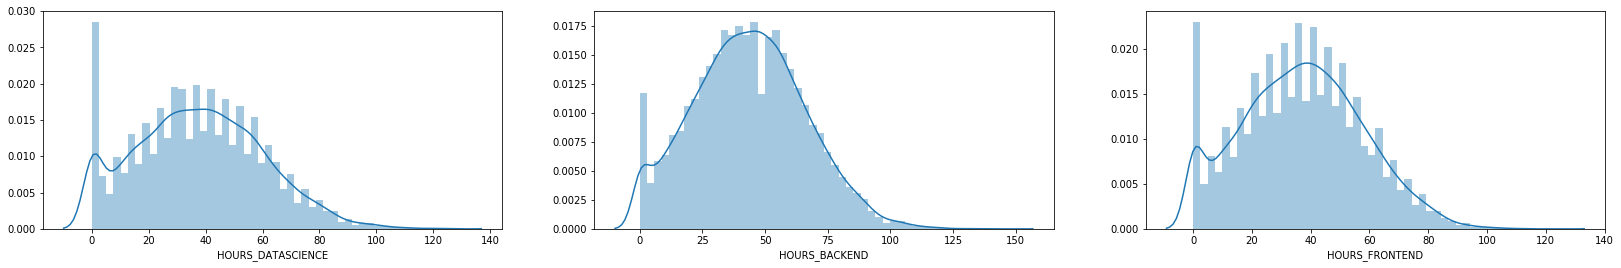

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 4))

sns.distplot(df_training['HOURS_DATASCIENCE'].dropna(), ax=axes[0])
sns.distplot(df_training['HOURS_BACKEND'].dropna(), ax=axes[1])
sns.distplot(df_training['HOURS_FRONTEND'].dropna(), ax=axes[2])

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(28, 4))

sns.distplot(df_training['NUM_COURSES_BEGINNER_DATASCIENCE'].dropna(), ax=axes[0][0])
sns.distplot(df_training['NUM_COURSES_BEGINNER_BACKEND'].dropna(), ax=axes[0][1])
sns.distplot(df_training['NUM_COURSES_BEGINNER_FRONTEND'].dropna(), ax=axes[0][2])
sns.distplot(df_training['NUM_COURSES_ADVANCED_DATASCIENCE'].dropna(), ax=axes[1][0])
sns.distplot(df_training['NUM_COURSES_ADVANCED_BACKEND'].dropna(), ax=axes[1][1])
sns.distplot(df_training['NUM_COURSES_ADVANCED_FRONTEND'].dropna(), ax=axes[1][2])

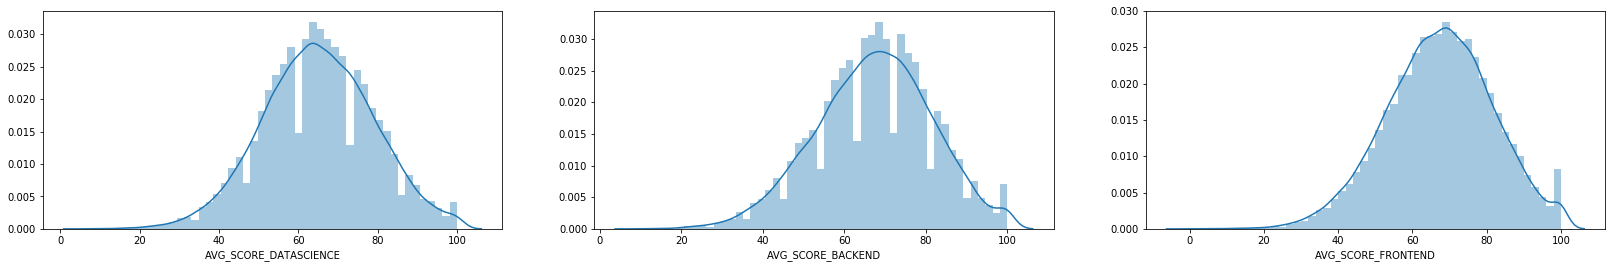

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 4))

sns.distplot(df_training['AVG_SCORE_DATASCIENCE'].dropna(), ax=axes[0])
sns.distplot(df_training['AVG_SCORE_BACKEND'].dropna(), ax=axes[1])
sns.distplot(df_training['AVG_SCORE_FRONTEND'].dropna(), ax=axes[2])

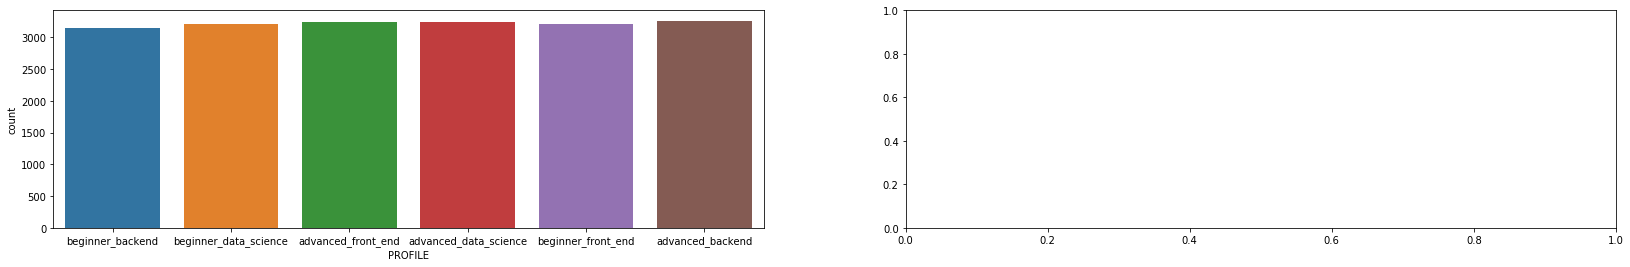

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 4))

sns.countplot(ax=axes[0], x='PROFILE', data=df_training)

# Eliminar Columnas no deseadas

In [15]:
df_training_dataset = df_training.drop(columns=['NAME', 'Unnamed: 0', 'USER_ID'], inplace=False)

In [16]:
print("Valores nulos antes de la transformación SimpleImputer: \n\n{}\n".format(df_training_dataset.isnull().sum(axis = 0)))

Valores nulos antes de la transformación SimpleImputer: 

HOURS_DATASCIENCE                   0
HOURS_BACKEND                       0
HOURS_FRONTEND                      0
NUM_COURSES_BEGINNER_DATASCIENCE    0
NUM_COURSES_BEGINNER_BACKEND        0
NUM_COURSES_BEGINNER_FRONTEND       0
NUM_COURSES_ADVANCED_DATASCIENCE    0
NUM_COURSES_ADVANCED_BACKEND        0
NUM_COURSES_ADVANCED_FRONTEND       0
AVG_SCORE_DATASCIENCE               0
AVG_SCORE_BACKEND                   0
AVG_SCORE_FRONTEND                  0
PROFILE                             0
dtype: int64



In [17]:
df_training_dataset.head()

HOURS_DATASCIENCE  HOURS_BACKEND  HOURS_FRONTEND  \
11               39.0           52.0            34.0   
12               28.0           44.0            16.0   
13               74.0           36.0            41.0   
14               69.0           40.0            18.0   
15               46.0          102.0            44.0   

    NUM_COURSES_BEGINNER_DATASCIENCE  NUM_COURSES_BEGINNER_BACKEND  \
11                               2.0                           4.0   
12                               3.0                           2.0   
13                               2.0                           5.0   
14                               4.0                           3.0   
15                               7.0                           9.0   

    NUM_COURSES_BEGINNER_FRONTEND  NUM_COURSES_ADVANCED_DATASCIENCE  \
11                            4.0                               1.0   
12                            5.0                               0.0   
13                            2.0                               3.0   
14                            5.0                               4.0   
15                            3.0                               5.0   

    NUM_COURSES_ADVANCED_BACKEND  NUM_COURSES_ADVANCED_FRONTEND  \
11                           5.0                            5.0   
12                           4.0                            4.0   
13                           4.0                            2.0   
14                           7.0                            6.0   
15                           3.0                            3.0   

    AVG_SCORE_DATASCIENCE  AVG_SCORE_BACKEND  AVG_SCORE_FRONTEND  \
11                   69.0               65.0                73.0   
12                   41.0               40.0                76.0   
13                   52.0               77.0                66.0   
14                   40.0               82.0                78.0   
15                   69.0               94.0                50.0   

                  PROFILE  
11       beginner_backend  
12  beginner_data_science  
13     advanced_front_end  
14  advanced_data_science  
15     advanced_front_end

# Sampling

In [18]:
Counter(df_training_dataset['PROFILE'])

Counter({'beginner_backend': 3147,
         'beginner_data_science': 3215,
         'advanced_front_end': 3244,
         'advanced_data_science': 3250,
         'beginner_front_end': 3209,
         'advanced_backend': 3263})

In [19]:
values = df_training_dataset.PROFILE.value_counts().to_dict()
classmax = max(values, key=values.get)
print(classmax, " :", values[classmax])

advanced_backend  : 3263


In [20]:
values = df_training_dataset.PROFILE.value_counts()

num_samples = values[classmax]
#num_samples = int(avg_data)

df_training_dataset = pd.concat([
    df_training_dataset[df_training_dataset['PROFILE'] == 'beginner_front_end'].sample(num_samples, replace=True),
    df_training_dataset[df_training_dataset['PROFILE'] == 'advanced_front_end'].sample(num_samples, replace=True),
    df_training_dataset[df_training_dataset['PROFILE'] == 'beginner_backend'].sample(num_samples, replace=True),
    df_training_dataset[df_training_dataset['PROFILE'] == 'advanced_backend'].sample(num_samples, replace=True),
    df_training_dataset[df_training_dataset['PROFILE'] == 'beginner_data_science'].sample(num_samples, replace=True),
    df_training_dataset[df_training_dataset['PROFILE'] == 'advanced_data_science'].sample(num_samples, replace=True)
], axis=0)

Beginner Frontend: 3263
Advance Frontend: 3263
Beginner Backend: 3263
Advance Backend: 3263
Beginner DataScience: 3263
Advance DataScience: 3263


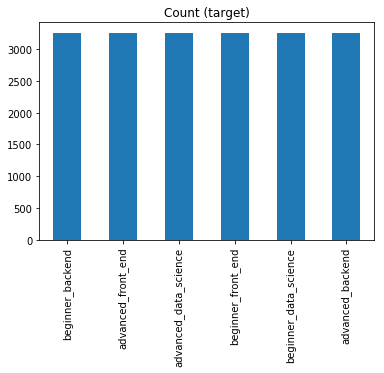

In [21]:
target_count = df_training_dataset.PROFILE.value_counts()
print('Beginner Frontend:', target_count['beginner_front_end'])
print('Advance Frontend:', target_count['advanced_front_end'])
print('Beginner Backend:', target_count['beginner_backend'])
print('Advance Backend:', target_count['advanced_backend'])
print('Beginner DataScience:', target_count['beginner_data_science'])
print('Advance DataScience:', target_count['advanced_data_science'])

target_count.plot(kind='bar', title='Count (target)');

#### Definición de features del modelo

In [22]:
# Definición de las columnas que seran features (Notese que la columna NOMBRE no esta presente)
features = np.array(df_training_dataset.columns)[:-1]

# Preparación de los argumentos para los métodos de la biblioteca ``scikit-learn``
X = df_training_dataset[features]
y = df_training_dataset['PROFILE']

#### Separar el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba

Separaremos el conjunto de datos provisto en dos grupos: uno para entrenar nuestro modelo y otro para probar el resultado a través de una prueba ciega. La separación del conjunto de datos se puede hacer fácilmente con el método *train_test_split ()* de scikit-learn:

In [23]:
# Separación de datos en conjunto de entrenamiento y conjunto de pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=337)

In [24]:
print('Resampled dataset shape %s' % Counter(y_train))

Resampled dataset shape Counter({'beginner_backend': 2792, 'advanced_data_science': 2781, 'beginner_front_end': 2772, 'advanced_front_end': 2768, 'advanced_backend': 2766, 'beginner_data_science': 2762})


In [25]:
sm = SMOTE(random_state=337)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [26]:
print('Resampled dataset shape %s' % Counter(y_train))

Resampled dataset shape Counter({'beginner_front_end': 2792, 'advanced_front_end': 2792, 'advanced_backend': 2792, 'advanced_data_science': 2792, 'beginner_data_science': 2792, 'beginner_backend': 2792})


#### Creando un modelo basado en árboles de decisión

En el ejemplo proporcionado, crearemos un clasificador basado en **árboles de decisión**.

El primer paso es básicamente crear una instancia de un objeto *DecisionTreeClassifier ()* de la biblioteca scikit-learn.

In [27]:
dtc_model = ExtraTreesClassifier(n_estimators=100, max_features='auto', criterion='entropy', random_state=337)
dtc_model.fit(X_train, y_train)

ExtraTreesClassifier(criterion='entropy', random_state=337)

In [28]:
dtc_model.feature_importances_

array([0.08894399, 0.09318411, 0.08673808, 0.07639192, 0.09291453,
       0.08420927, 0.07054836, 0.08457059, 0.07232353, 0.08786919,
       0.07281795, 0.08948847])

<BarContainer object of 12 artists>

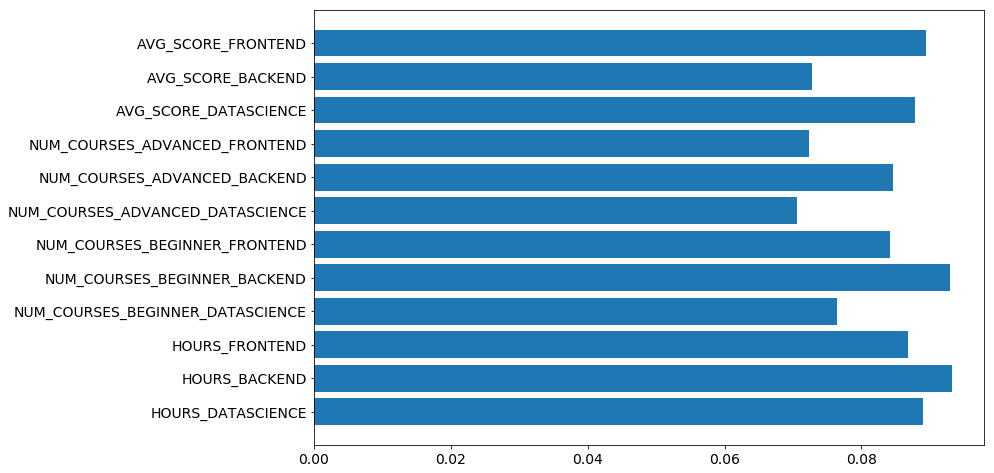

In [29]:
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

plt.barh(np.array(np.array(df_training_dataset.columns)[:-1]),
         dtc_model.feature_importances_)

Material teórico sobre árboles de decisión en la documentación oficial de scikit-learn: https://scikit-learn.org/stable/modules/tree.html

Una guía para principiantes del mundo del aprendizaje automático: https://developer.ibm.com/es/patterns/use-icp4d-to-build-the-machine-learning-model-for-return-propensity/

#### Ejecución de predicciones y evaluación del modelo creado

In [30]:
# Realización de una prueba a ciegas en el modelo creado
y_pred = dtc_model.predict(X_test)

In [31]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[482   9   0   2   1   3]
 [  3 463   5   2   7   2]
 [  0   5 481   2   1   6]
 [  4  10   2 444   9   2]
 [  1   6   3   1 486   4]
 [  1   0   6   2   0 482]]
                       precision    recall  f1-score   support

     advanced_backend       0.98      0.97      0.98       497
advanced_data_science       0.94      0.96      0.95       482
   advanced_front_end       0.97      0.97      0.97       495
     beginner_backend       0.98      0.94      0.96       471
beginner_data_science       0.96      0.97      0.97       501
   beginner_front_end       0.97      0.98      0.97       491

             accuracy                           0.97      2937
            macro avg       0.97      0.97      0.97      2937
         weighted avg       0.97      0.97      0.97      2937

0.9662921348314607


In [32]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [33]:
targets = np.array(y.unique())

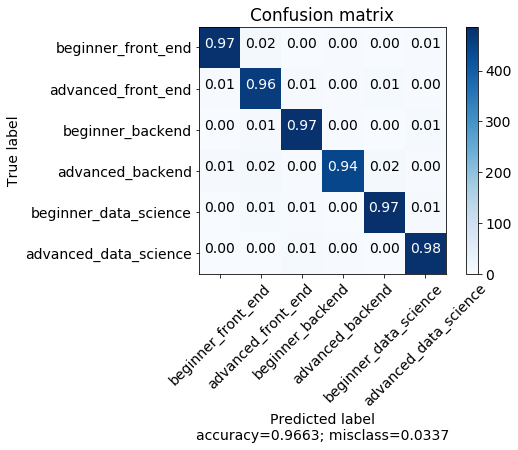

In [34]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), targets)

In [35]:
# Precisión lograda por el árbol de decisiones
print("Exactitud: {}%".format(100*round(accuracy_score(y_test, y_pred), 2)))

Exactitud: 97.0%


<hr>

## Puntuación de los datos necesarios para entregar la solución

Como entrega de su solución, esperamos que los resultados se clasifiquen en el siguiente dataset llamado "to_be_scored_tortuga_fix.csv":

### Descarga la "hoja de evaluación"

In [36]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset-tortuga/master/to_be_scored_tortuga_fix.csv
df_to_be_scored = pd.read_csv(r'to_be_scored_tortuga_fix.csv')
df_to_be_scored.tail()

--2020-09-07 06:46:31--  https://raw.githubusercontent.com/vanderlei-test/dataset-tortuga/master/to_be_scored_tortuga_fix.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29095 (28K) [text/plain]
Saving to: ‘to_be_scored_tortuga_fix.csv.3’

100%[======================================>] 29,095      --.-K/s   in 0.001s  

2020-09-07 06:46:31 (27.4 MB/s) - ‘to_be_scored_tortuga_fix.csv.3’ saved [29095/29095]



Unnamed: 0           NAME   USER_ID  HOURS_DATASCIENCE  HOURS_BACKEND  \
495         506  Eileen Finley   1147648                  0             56   
496         507    Cedric Buss  33729943                 50             53   
497         508      James Ray  62724217                 35             35   
498         509    Lauren Vega  71562358                 42              4   
499         510   Joshua Brown  48754463                  6             47   

     HOURS_FRONTEND  NUM_COURSES_BEGINNER_DATASCIENCE  \
495              11                                 2   
496               5                                 4   
497              63                                 3   
498              58                                 6   
499              39                                 5   

     NUM_COURSES_BEGINNER_BACKEND  NUM_COURSES_BEGINNER_FRONTEND  \
495                             1                              8   
496                             1                              4   
497                             0                              0   
498                             6                              5   
499                             2                              8   

     NUM_COURSES_ADVANCED_DATASCIENCE  NUM_COURSES_ADVANCED_BACKEND  \
495                                 5                             2   
496                                 8                             4   
497                                 5                             3   
498                                 7                             7   
499                                 5                             4   

     NUM_COURSES_ADVANCED_FRONTEND  AVG_SCORE_DATASCIENCE  AVG_SCORE_BACKEND  \
495                              6                     80                 93   
496                              4                     59                 59   
497                              5                     35                 54   
498                              5                     78                 59   
499                              9                     88                 83   

     AVG_SCORE_FRONTEND  
495                  35  
496                  50  
497                  59  
498                  79  
499                  61

# ¡Atención!

El Dataframe ``to_be_scored_tortuga`` es su "hoja de evaluación". Tenga en cuenta que la columna "PROFILE" hace falta en este dataset de evaluación, por lo que no se puede usar para entrenar modelos de aprendizaje supervisado.

In [37]:
len(df_to_be_scored)

500

In [38]:
print("Cols: ", len(df_to_be_scored.columns), " Rows: ", len(df_training))

Cols:  15  Rows:  19328


In [39]:
print("Valores nulos antes de la transformación SimpleImputer: \n\n{}\n".format(df_to_be_scored.isnull().sum(axis = 0)))

Valores nulos antes de la transformación SimpleImputer: 

Unnamed: 0                          0
NAME                                0
USER_ID                             0
HOURS_DATASCIENCE                   0
HOURS_BACKEND                       0
HOURS_FRONTEND                      0
NUM_COURSES_BEGINNER_DATASCIENCE    0
NUM_COURSES_BEGINNER_BACKEND        0
NUM_COURSES_BEGINNER_FRONTEND       0
NUM_COURSES_ADVANCED_DATASCIENCE    0
NUM_COURSES_ADVANCED_BACKEND        0
NUM_COURSES_ADVANCED_FRONTEND       0
AVG_SCORE_DATASCIENCE               0
AVG_SCORE_BACKEND                   0
AVG_SCORE_FRONTEND                  0
dtype: int64



<hr>

# ¡Atención!

# Para aplicar su modelo y clasificar la hoja de evaluación, primero debe aplicar las mismas transformaciones de columnas que aplicó al conjunto de datos de entrenamiento.

# No elimine ni agregue líneas a la hoja de respuestas.

# No cambie el orden de las líneas en la hoja de respuestas.

# Al final, se deben clasificar las 500 entradas, con los valores proporcionados en la columna "target"

<hr>

En la celda de abajo, repetimos rápidamente los mismos pasos de preprocesamiento usados ​​en el ejemplo dado con el árbol de decisiones

In [40]:
df_to_be_scored_2 = df_to_be_scored.drop(columns=['NAME', 'Unnamed: 0', 'USER_ID'], inplace=False)

In [41]:
df_to_be_scored_2.head()

HOURS_DATASCIENCE  HOURS_BACKEND  HOURS_FRONTEND  \
0                 84             30               0   
1                 42             74              13   
2                 18             76              38   
3                 77             29              23   
4                 35             14              39   

   NUM_COURSES_BEGINNER_DATASCIENCE  NUM_COURSES_BEGINNER_BACKEND  \
0                                 4                             6   
1                                 3                             6   
2                                 5                             2   
3                                 7                             2   
4                                 0                             5   

   NUM_COURSES_BEGINNER_FRONTEND  NUM_COURSES_ADVANCED_DATASCIENCE  \
0                              3                                 3   
1                              4                                 2   
2                              8                                 8   
3                              6                                 1   
4                              3                                 2   

   NUM_COURSES_ADVANCED_BACKEND  NUM_COURSES_ADVANCED_FRONTEND  \
0                             7                              6   
1                             7                              5   
2                             3                              8   
3                             6                              1   
4                             8                              3   

   AVG_SCORE_DATASCIENCE  AVG_SCORE_BACKEND  AVG_SCORE_FRONTEND  
0                     51                 74                  37  
1                     82                 59                  50  
2                     77                 53                  50  
3                     68                 57                  60  
4                     63                 82                  91

In [42]:
# Realización de una prueba a ciegas en el modelo creado
y_pred = dtc_model.predict(df_to_be_scored_2)

In [43]:
# Agregando las respuestas en la columna "target"
df_to_be_scored_2['target'] = y_pred
df_to_be_scored_2.tail()

HOURS_DATASCIENCE  HOURS_BACKEND  HOURS_FRONTEND  \
495                  0             56              11   
496                 50             53               5   
497                 35             35              63   
498                 42              4              58   
499                  6             47              39   

     NUM_COURSES_BEGINNER_DATASCIENCE  NUM_COURSES_BEGINNER_BACKEND  \
495                                 2                             1   
496                                 4                             1   
497                                 3                             0   
498                                 6                             6   
499                                 5                             2   

     NUM_COURSES_BEGINNER_FRONTEND  NUM_COURSES_ADVANCED_DATASCIENCE  \
495                              8                                 5   
496                              4                                 8   
497                              0                                 5   
498                              5                                 7   
499                              8                                 5   

     NUM_COURSES_ADVANCED_BACKEND  NUM_COURSES_ADVANCED_FRONTEND  \
495                             2                              6   
496                             4                              4   
497                             3                              5   
498                             7                              5   
499                             4                              9   

     AVG_SCORE_DATASCIENCE  AVG_SCORE_BACKEND  AVG_SCORE_FRONTEND  \
495                     80                 93                  35   
496                     59                 59                  50   
497                     35                 54                  59   
498                     78                 59                  79   
499                     88                 83                  61   

                    target  
495       advanced_backend  
496       advanced_backend  
497  beginner_data_science  
498     beginner_front_end  
499       advanced_backend

In [44]:
print(Counter(y_pred))

Counter({'beginner_front_end': 95, 'advanced_data_science': 88, 'beginner_data_science': 84, 'advanced_front_end': 82, 'beginner_backend': 76, 'advanced_backend': 75})


### Guardar la hoja de respuestas como un archivo .csv para enviar
**SI YA TIENE UN DATA ASSET CON EL NOMBRE `results.csv` EN ESTE PROYECTO O EN OTRO PROYECTO DE WATSON STUDIO DEBE BORRAR EL ARCHIVO ANTES DE CORRER LA SIGUIENTE CELDA O TENDRA EL ERROR: _RuntimeError: File 'results.csv' already exists in storage._**

In [46]:
project.save_data(file_name="results.csv", data=df_to_be_scored_2.to_csv(index=False))

{'file_name': 'results.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'tortuga-donotdelete-pr-1bjvkojpasdupt',
 'asset_id': '2089ebe5-7034-434c-97de-5d5330b59fba'}

# Atención

# La ejecución de la celda anterior creará un nuevo "data asset" en su proyecto de Watson Studio. Deberá descargar este archivo junto con este cuaderno y crear un archivo zip con **results.csv** y **notebook.ipynb** para enviarlo. (los archivos deben tener este nombre)

<hr>

## ¡Felicitaciones!

Si ya está satisfecho con su solución, vaya a la página siguiente y envíe los archivos necesarios para su envío.

# https://tortuga.maratona.dev